## Multilayer Perceptron for Normalized GEMs

Author: Brad Selee

A PyTorch implementation of a feed-forward neural network to classify RNA expression matrices into cancerous or non-cancerous samples. This notebook reads in two files: the sample file which is the log transformed Gene Expression Matrix with quantile normalization.   

You must use a p100 or greater GPU, PyTorch does not support K20s and 40s.

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
import sys
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

### Define Classes

In [2]:
class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, data, input_num_classes, output_num_classes):
        """
        Initialization
        data - normalized sample data 2 indexes wide the first index is the sample data and
               the second index is the label (numpy array)
        input_num_classes - represents the normalization range to create one-hot labels. 
        output_num_classes - number of labels that are being classified 
        """
        self.input_num_classes  = input_num_classes
        self.output_num_classes = output_num_classes
        self.data_input = data[0]
        self.data_output = data[1]
        assert len(self.data_input) == len(self.data_output)
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data_input)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        '''
        return (torch.nn.functional.one_hot(torch.tensor(self.data_input[index]),
                                            num_classes=self.input_num_classes),
                torch.nn.functional.one_hot(torch.tensor(self.data_output[index]),
                                            num_classes=self.output_num_classes),)
        '''
        '''
        return (torch.nn.functional.one_hot(torch.tensor(self.data_input[index]),
                                            num_classes=self.input_num_classes),
                torch.tensor(self.data_output[index]))
        '''
        return (torch.tensor(self.data_input[index]), torch.tensor(self.data_output[index]))

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [4]:
# TODO: gain a better understanding of dropout layers
class Net(nn.Module):
    def __init__(self,  input_seq_length, input_num_classes, output_num_classes):
        super(Net, self).__init__()
        self.input_seq_length = input_seq_length
        self.input_num_classes = input_num_classes
        self.output_num_classes = output_num_classes

        self.fc1 = nn.Linear(1*self.input_seq_length, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)        
        self.fc4 = nn.Linear(256, output_num_classes)
        self.dropout = nn.Dropout(p=0.5, inplace=False)

    def forward(self, x):
        x = x.view(x.shape[0], 1*self.input_seq_length* 1)
        x = F.relu(self.fc1(x))
        #x = self.dropout(x)
        x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = F.relu(self.fc3(x))
        #x = self.dropout(x)
        x = self.fc4(x)
        # Note:
        #   Softmax activation for output layer is not used because the nn.CrossEntropyLoss
        #   automatically applies it, so we just send it the raw output. The most likely
        #   class will be the index with the highest value. If probability is needed, the
        #   softmax function can be called when calculating accuracy, this is shown in the
        #   multi_acc function. Ultimately, the softmax as thelast activation function won't 
        #   change the classification result.
        return x

### Define Functions

In [5]:
def labels_and_weights(label_file_df):
    """ 
     Get list of unique sample labels and weights of the samples using
     the inverse of the count. Weights is a tensor to be compatible with
     CrossEntropyLoss.
    """
        
    labels_all = label_file_df.iloc[:,-1].astype(str).values.tolist()
    labels_unique = set(labels_all)
    labels = sorted(labels_unique)
    
    labels_count = [labels_all.count(label) for label in labels]
    weights = 1. / torch.tensor(labels_count, dtype=torch.float) 
    
    return labels, weights


In [6]:
def split_data(matrix_transposed_df, label_file_df, num_classes=4):
    """ merge sample and label file """
    
    # Create dictionary of labels - key:labels, value:indices
    labels = label_file_df.iloc[:,-1].astype(str).values.tolist()
    labels_unique = set(labels)
    labels = sorted(labels_unique)
    labels_dict = {k:v for v, k in enumerate(labels)}
    
    merged_df = pd.merge(matrix_transposed_df, labels_df, left_index=True, right_on='sample')
    del merged_df['sample']
    merged_df['label'].replace(labels_dict, inplace=True)
    
    X = merged_df.iloc[:, 0:-1]
    y = merged_df.iloc[:, -1]
    
    # stratify=y weights the train and test labels properly
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)
    
    return (X_train, y_train), (X_test, y_test)
    

In [7]:
def plot(train_stats, test_stats, y_target_list, y_pred_list, labels,
         graphs_title="Training vs Validation", cm_title="Confusion Matrix"):
    """Plot training/validation accuracy/loss and Confusion Matrix"""

    # Set up dimensions for plots
    dimensions = (7,12)
    fig, axis = plt.subplots(figsize=dimensions)

    # Plot CM
    confusion_matrix_df = pd.DataFrame(confusion_matrix(y_target_list, y_pred_list))
    sns_heatmap=sns.heatmap(confusion_matrix_df, ax=axis, annot=True, cbar=False,
                                square=True, xticklabels=labels, yticklabels=labels)
    axis.set_title(cm_title)
    axis.set_ylabel("Actual")
    axis.set_xlabel("Predicted")
    
    # Plot Accuracy
    figure = plt.figure()
    figure.set_figheight(12)
    figure.set_figwidth(7)
    plot1 = figure.add_subplot(211)
    plot1.plot(train_stats['accuracy'])
    plot1.plot(test_stats['accuracy'])
    plot1.set_title(graphs_title)
    plot1.set_ylabel("Accuracy")
    plot1.set_xlabel("Epoch")
    plt.legend(["Training", "Testing"], loc="upper left")

    # Plot Loss 
    plot2 = figure.add_subplot(212)
    plot2.plot(train_stats['loss'])
    plot2.plot(test_stats['loss'])
    plot2.set_title(graphs_title)
    plot2.set_ylabel("Loss")
    plot2.set_xlabel("Epoch")
    plot2.legend(["Training", "Testing"], loc="upper left")

    # Save plots into pdf
    #plt.savefig(os.path.join(OUTPUT_DIR, 'stats.pdf'))
    #sns_heatmap.figure.savefig(os.path.join(OUTPUT_DIR, "confusion_matrix.pdf"))

In [8]:
def multi_accuracy(actual_labels, predicted_labels):
    """Computes the accuracy for multiclass predictions"""
    pred_labels_softmax = torch.softmax(predicted_labels, dim=1)
    _, pred_labels_tags = torch.max(pred_labels_softmax, dim=1)

    correct = (pred_labels_tags == actual_labels).float()
    return correct.sum()

## Main Workflow

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(use_cuda)

train_kwargs = {'batch_size': 16}
test_kwargs = {'batch_size': 16}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

True


### Initialization

In [10]:
# Define file paths
SAMPLE_FILE = "lung.emx.txt"
LABEL_FILE = "sample_condition.txt"

In [11]:
## Load Data
matrix_df = pd.read_csv(SAMPLE_FILE, sep='\t')
matrix_df.head()

,TCGA.05.5420.01A.01R.1628.07,TCGA.55.7283.01A.11R.2039.07,TCGA.55.8208.01A.11R.2241.07,TCGA.75.6205.01A.11R.1755.07,TCGA.44.8117.01A.11R.2241.07,TCGA.MP.A4TA.01A.21R.A24X.07,TCGA.86.8669.01A.11R.2403.07,TCGA.86.8668.01A.11R.2403.07,TCGA.44.A4SS.01A.11R.A24X.07,TCGA.55.7227.01A.11R.2039.07,...,GTEX.11ZTS.1226.SM.5EQMQ,GTEX.12WSL.1026.SM.5CVNJ,GTEX.14A6H.0526.SM.5NQAZ,GTEX.QMRM.0826.SM.3NB33,GTEX.QEG5.1126.SM.33HC2,GTEX.144GO.0226.SM.5LUB1,GTEX.OHPM.0526.SM.2YUMJ,GTEX.13OVG.0326.SM.5KM57,GTEX.WYVS.0526.SM.3NM9W,GTEX.131XH.0426.SM.5DUWU
HIST3H2A,9.809754,2.954724,4.873680,6.735488,4.229448,9.403950,9.239499,5.377771,6.620636,7.551631,...,7.013502,6.579360,2.779043,4.290058,5.065629,8.610875,2.823402,4.035995,6.363210,7.138397
LIN7B,8.894070,5.997310,7.588527,6.751384,7.404094,7.052481,7.639914,6.960350,6.849096,6.815561,...,6.652898,7.326125,7.813368,6.736590,6.400787,6.470978,4.611742,7.042791,6.534886,6.620885
LXN,10.185433,8.375249,10.545116,8.989366,8.228698,8.979396,7.876990,8.551951,9.859755,9.352365,...,8.973689,10.075573,10.725301,8.983359,9.354334,9.349722,8.064545,8.594468,11.275207,8.937756
CNKSR2,0.975818,3.202099,2.356563,2.522910,1.247788,1.214410,3.730376,3.636132,2.301068,3.736715,...,6.138962,3.906332,3.635977,6.441998,5.255572,5.474813,5.667572,6.736665,3.185818,5.077322
SCML1,8.783611,5.817718,7.499751,6.001749,5.588392,5.498967,7.123027,6.673380,7.082229,7.308943,...,8.277807,6.534039,7.056894,6.836865,8.559605,8.933818,6.236766,7.974580,6.333311,8.398369


In [12]:
column_names = ("sample", "label")
labels_df = pd.read_csv(LABEL_FILE, names=column_names, delim_whitespace=True, header=None)
labels, class_weights = labels_and_weights(labels_df)
print(len(labels_df))
print(len(matrix_df.columns))
assert len(labels_df) == len(matrix_df.columns) 
print(len(labels_df))
print(len(matrix_df.columns))
print(labels)
print(class_weights)

1415
1415
1415
1415
['GTEx_normal', 'TCGA-LUAD', 'TCGA-LUSC', 'TCGA-NORMAL']
tensor([0.0032, 0.0020, 0.0020, 0.0091])


In [13]:
## Define parameters
batch_size = 16
max_epoch = 50
learning_rate = 0.001 #5e-4
num_features = len(matrix_df.index)
num_classes = len(labels)

## Create model structure
model = Net(input_seq_length=num_features,
          input_num_classes=10,
          output_num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=50)
loss_fn = torch.nn.CrossEntropyLoss()#(weight=class_weights)

### Data Preprocessing and Visualizaiton

<AxesSubplot:>

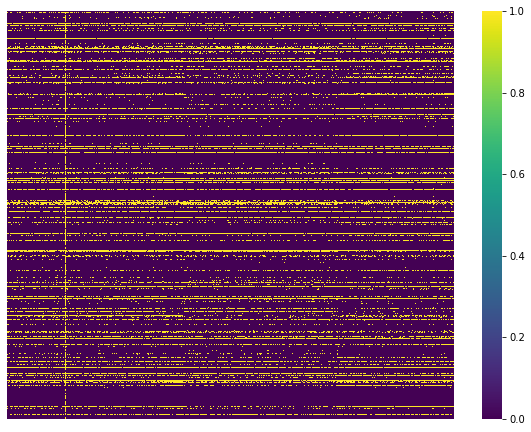

In [14]:
# Visualize missing data ~16k rows ~1400 columns
# yellow => missing data
plt.figure(figsize=(10, 7.5))
sns.heatmap(matrix_df.isnull(), xticklabels=False, yticklabels=False, cmap="viridis")

1415
(19648, 1415)


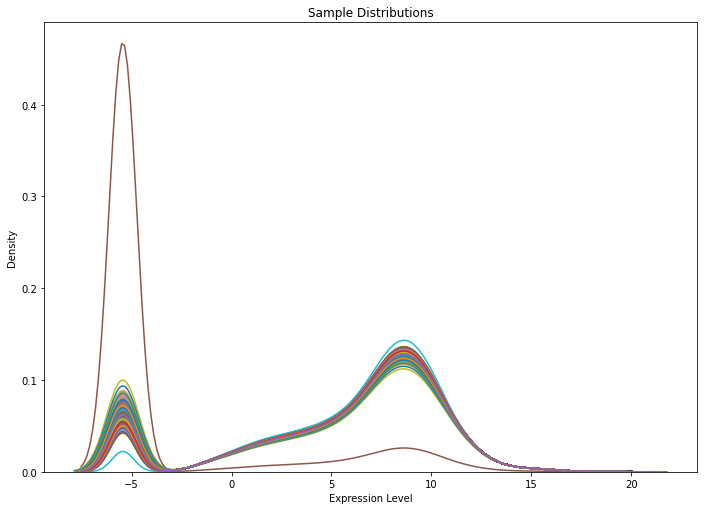

In [15]:
# Replace nan values with the global minimum of the data set, not independent of rows
# Then plot the density curve
val_min, val_max = np.nanmin(matrix_df), np.nanmax(matrix_df)
matrix_df.fillna(val_min, inplace=True)
i = 0
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)
for column in matrix_df:
    i = i+1
    sns.kdeplot(matrix_df[column], legend=False, ax=ax)

plt.title("Sample Distributions")
plt.xlabel("Expression Level")
plt.ylabel("Density")
plt.savefig("density.pdf")
print(i)
print(matrix_df.shape)

In [16]:
# Transposing matrix to align with label file
matrix_transposed_df = matrix_df.T
matrix_transposed_df.head()

,HIST3H2A,LIN7B,LXN,CNKSR2,SCML1,AC024592.12,GSDMD,AKR1C1,C3orf62,CRISPLD2,...,UFM1,LRRN4,UBE2T,ZNF521,SPINT2,HAVCR2,RP1-66C13.4,C3orf79,CTD-2116N17.1,FUT2
TCGA.05.5420.01A.01R.1628.07,9.809754,8.894070,10.185433,0.975818,8.783611,6.921894,12.309936,10.009508,6.447163,8.602676,...,10.947737,2.818089,10.450404,4.767401,12.628039,9.905492,-5.445457,-5.445457,3.550536,9.137858
TCGA.55.7283.01A.11R.2039.07,2.954724,5.997310,8.375249,3.202099,5.817718,5.921278,11.652147,7.742703,6.405290,8.202206,...,10.083141,9.410719,9.715043,4.556425,13.087273,7.536207,-5.445457,-5.445457,1.917661,8.652558
TCGA.55.8208.01A.11R.2241.07,4.873680,7.588527,10.545116,2.356563,7.499751,4.933090,11.092924,12.692244,6.824476,9.761226,...,10.267755,5.964174,8.030763,6.363371,13.502653,9.165130,-5.445457,0.528408,-5.445457,7.138142
TCGA.75.6205.01A.11R.1755.07,6.735488,6.751384,8.989366,2.522910,6.001749,4.638375,10.888794,10.759018,6.584466,9.714556,...,9.345621,5.013000,9.062355,6.691731,13.639007,9.482344,-5.445457,1.320742,2.251746,7.393969
TCGA.44.8117.01A.11R.2241.07,4.229448,7.404094,8.228698,1.247788,5.588392,5.326840,10.430217,7.013077,6.462044,8.719946,...,9.935808,9.052596,9.347241,5.960314,13.694899,7.521532,-5.445457,-5.445457,2.476251,7.318292


In [17]:
train_data, test_data = split_data(matrix_transposed_df, labels_df, num_classes)

In [18]:
train_data[0].head()

,HIST3H2A,LIN7B,LXN,CNKSR2,SCML1,AC024592.12,GSDMD,AKR1C1,C3orf62,CRISPLD2,...,UFM1,LRRN4,UBE2T,ZNF521,SPINT2,HAVCR2,RP1-66C13.4,C3orf79,CTD-2116N17.1,FUT2
1250,4.700754,6.765208,9.756074,6.918910,7.013528,3.521292,11.265947,9.213301,7.046638,7.899387,...,10.278530,5.608698,5.454939,8.863714,11.504373,8.315510,-5.445457,-5.445457,-2.216190,3.778335
1275,1.202101,6.389813,9.402646,4.506859,7.335214,3.071190,11.405372,5.540678,7.690393,10.737545,...,10.433427,9.488100,5.355596,6.595490,12.465894,8.559023,-5.445457,-5.445457,-5.445457,5.770946
293,8.691972,8.218423,9.519911,0.450324,9.503160,6.269844,11.290849,13.920489,6.065536,8.074291,...,11.823773,2.880630,10.895480,6.312320,14.152163,7.263716,-5.445457,-5.445457,3.853776,8.598850
703,7.640818,7.630273,9.462736,1.967630,6.928642,5.307427,11.369412,12.276759,6.743801,10.218405,...,10.590571,1.231110,10.700044,6.650295,13.583658,7.223371,-5.445457,-5.445457,4.157222,7.277376
1318,4.990840,7.439739,9.397785,5.276445,7.069774,4.838302,10.155681,11.417950,6.620623,9.329889,...,10.030343,8.818556,7.113514,5.507593,12.568806,8.632561,-5.445457,-5.445457,2.225761,4.288354


In [19]:
train_data[1].head()

1250    0
1275    0
293     1
703     2
1318    0
Name: label, dtype: int64

In [20]:
# Convert tuple of df's to tuple of np's
# Allows the dataset class to access w/ data[][] instead of data[].iloc[]
train_data_np = (train_data[0].values, train_data[1].values)
test_data_np = (test_data[0].values, test_data[1].values)

train_dataset = Dataset(train_data_np,input_num_classes=10, output_num_classes=num_classes)
test_dataset = Dataset(test_data_np, input_num_classes=10,output_num_classes=num_classes)
train_generator = data.DataLoader(train_dataset, **train_kwargs, drop_last=False)
test_generator = data.DataLoader(test_dataset, **test_kwargs, drop_last=False)

### Train and test the network

In [21]:
# Meter object to keep track of loss
loss_avgmeter = AverageMeter()

# Dataframes to keep track of statistics
summary_file = pd.DataFrame([], columns=['Epoch', 'Training Loss', 'Accuracy', 'Accurate Count', 'Total Items'])
train_stats = pd.DataFrame([], columns=['accuracy', 'loss'])
test_stats = pd.DataFrame([], columns=['accuracy', 'loss'])

for epoch in range(max_epoch):
    model.train()
    total_items = 0
    acc = 0.0

    # Training 
    for data, target in train_generator:
        data = data.unsqueeze(1).float()
        data, target = data.to(device), target.to(device)
        total_items += target.shape[0] 
        # Zero out the gradients
        optimizer.zero_grad()
        # Predict in-sample labels and get training accuracy
        prediction = model(data)
        acc += multi_accuracy(target, prediction)
        loss = loss_fn(prediction, target.long())
        # Compute gradients and update weights
        loss.backward()
        optimizer.step()

    # Calculate loss per epoch
    loss_avgmeter.update(loss.item(), batch_size)
    acc_avg = acc/total_items
    temp_stats = pd.DataFrame([[acc_avg, loss_avgmeter.avg]], columns=['accuracy', 'loss'])
    train_stats = train_stats.append(temp_stats, ignore_index=True)

    model.eval()
    total_items = 0
    correct = 0
    acc = 0.0
    acc_avg = 0.0
    loss_avgmeter.reset()
    
    # Skip gradient calculation to improve speed
    
    with torch.no_grad():
        # Testing
        for data, target in test_generator:
            data = data.unsqueeze(1).float()
            data, target = data.to(device), target.to(device)
            total_items += target.shape[0]
            # Predict out-sample labels (samples network hasn't seen) and get validation accuracy
            prediction = model(data)
            acc += multi_accuracy(target, prediction)
            loss = loss_fn(prediction, target.long())
            loss_avgmeter.update(loss.item(), batch_size)
    
    acc_avg = acc/total_items
    temp_stats = pd.DataFrame([[acc_avg, loss_avgmeter.avg]], columns=['accuracy', 'loss'])
    test_stats = test_stats.append(temp_stats, ignore_index=True)

    run_file = pd.DataFrame([['%d' %epoch, '%2.5f' %train_stats.iloc[epoch]['loss'], '%2.3f' %acc_avg, '%d' % acc, '%d' % total_items]], columns=['Epoch', 'Training Loss', 'Accuracy', 'Accurate Count', 'Total Items'])
    print('Epoch: %d Training Loss: %2.5f Test Accuracy : %2.3f Accurate Count: %d Total Items :%d '% (epoch, train_stats.iloc[epoch]['loss'], acc_avg, acc, total_items))
    scheduler.step(acc)
    loss_avgmeter.reset()
    

Epoch: 0 Training Loss: 0.29266 Test Accuracy : 0.725 Accurate Count: 308 Total Items :425 
Epoch: 1 Training Loss: 0.21040 Test Accuracy : 0.864 Accurate Count: 367 Total Items :425 
Epoch: 2 Training Loss: 0.41732 Test Accuracy : 0.864 Accurate Count: 367 Total Items :425 
Epoch: 3 Training Loss: 0.15339 Test Accuracy : 0.925 Accurate Count: 393 Total Items :425 
Epoch: 4 Training Loss: 0.31875 Test Accuracy : 0.866 Accurate Count: 368 Total Items :425 
Epoch: 5 Training Loss: 0.34482 Test Accuracy : 0.866 Accurate Count: 368 Total Items :425 
Epoch: 6 Training Loss: 0.01572 Test Accuracy : 0.951 Accurate Count: 404 Total Items :425 
Epoch: 7 Training Loss: 0.04700 Test Accuracy : 0.906 Accurate Count: 385 Total Items :425 
Epoch: 8 Training Loss: 0.12377 Test Accuracy : 0.936 Accurate Count: 398 Total Items :425 
Epoch: 9 Training Loss: 0.29914 Test Accuracy : 0.765 Accurate Count: 325 Total Items :425 
Epoch: 10 Training Loss: 0.01486 Test Accuracy : 0.925 Accurate Count: 393 Total

In [22]:
# List to store predictions and actual labels for confusion matrix
y_pred_list = []
y_target_list = []

# Run test set to get confusion matrix values
with torch.no_grad():
    for data, target in test_generator:
        data = data.unsqueeze(1).float()
        data, target = data.to(device), target.to(device)
        total_items += target.shape[0]
        prediction = model(data)
        prediction_softmax = torch.softmax(prediction, dim=1)
        _, prediction_tags = torch.max(prediction_softmax, dim=1)
        y_pred_list.append(prediction_tags.to('cpu'))
        y_target_list.append(target.to('cpu'))

y_pred_list = [j for val in y_pred_list for j in val]
y_target_list = [j for val in y_target_list for j in val]

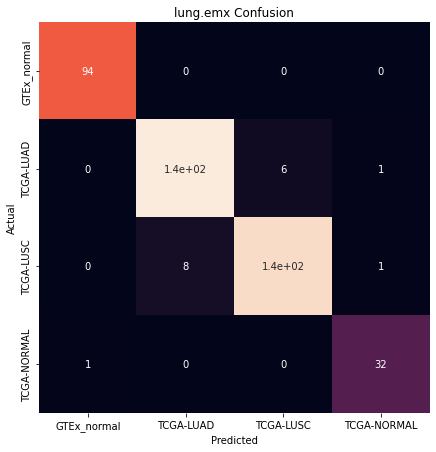

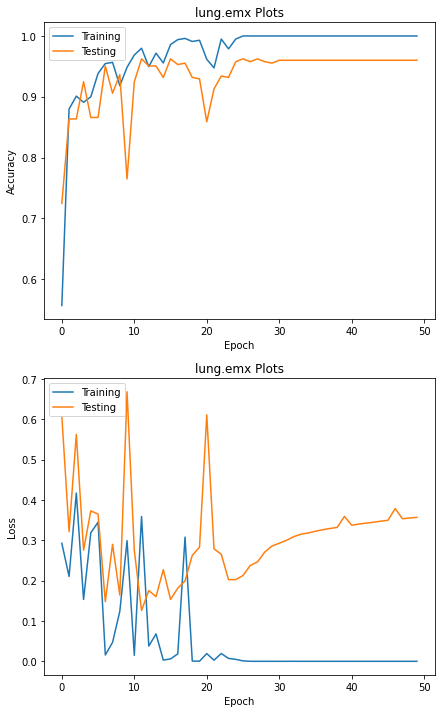

In [23]:
plot(train_stats, test_stats, y_target_list, y_pred_list, labels,
            graphs_title="lung.emx Plots", cm_title="lung.emx Confusion")

In [24]:
print("f1 score: %0.2f" % (f1_score(y_target_list, y_pred_list, average="weighted")))

f1 score: 0.96
